In [ ]:
# First, I will import my data using the below code:

In [ ]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import re
import datetime

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [170902, 170909, 170916, 170923, 170930, 171007, 171014, 171021, 171028, 171104, 171111, 171118, 171125, 171202,
            171209, 171216, 171223, 171230]
turnstiles = get_data(week_nums)

In [3]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882


In [7]:
turnstiles.shape

(3566289, 11)

In [4]:
turnstiles.columns #I need to strip the stirngs in column in order to remove whitespaces

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [5]:
turnstiles.columns = [column.strip() for column in turnstiles.columns]
turnstiles.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [12]:
#turnstiles.DATE.value_counts().sort_index()

In [11]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882


In [ ]:
#I will combine and convert the DATE and TIME columns 

In [6]:
turnstiles["DATE_TIME"] = pd.to_datetime(turnstiles.DATE + " " + turnstiles.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [7]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,REGULAR,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,REGULAR,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,REGULAR,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,REGULAR,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,REGULAR,6303508,2133882,2017-08-26 16:00:00


In [9]:
turnstiles.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE                 object
TIME                 object
DESC                 object
ENTRIES               int64
EXITS                 int64
DATE_TIME    datetime64[ns]
dtype: object

In [8]:
(turnstiles
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
385897,C014,R246,00-00-00,PROSPECT AV,2017-10-29 08:00:00,2
413411,C023,R213,00-00-01,BAY RIDGE AV,2017-10-09 16:00:00,2
412902,C023,R213,00-00-00,BAY RIDGE AV,2017-10-09 16:00:00,2
412903,C023,R213,00-00-00,BAY RIDGE AV,2017-10-09 20:00:00,2
412904,C023,R213,00-00-00,BAY RIDGE AV,2017-10-10 00:00:00,2


In [9]:
turnstiles.DESC.value_counts()

REGULAR       3554497
RECOVR AUD      11792
Name: DESC, dtype: int64

In [10]:
#we need to remove recovery audtis as below:
turnstiles = turnstiles[turnstiles['DESC'] != 'RECOVR AUD']

In [13]:
turnstiles.DESC.unique()

array(['REGULAR'], dtype=object)

In [11]:
#I will drop the description column since we don't need it anymore
turnstiles = turnstiles.drop(["DESC"], axis=1, errors="ignore")

In [12]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,6303508,2133882,2017-08-26 16:00:00


In [32]:
#I will look for missing values
turnstiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3554497 entries, 0 to 197212
Data columns (total 11 columns):
C/A          object
UNIT         object
SCP          object
STATION      object
LINENAME     object
DIVISION     object
DATE         object
TIME         object
ENTRIES      int64
EXITS        int64
DATE_TIME    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 325.4+ MB


In [13]:
turnstiles.isna().sum() #no null values found

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

In [14]:
turnstiles.isna()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False


In [15]:
turnstiles.shape

(3554497, 11)

In [16]:
#we will check if we have duplicate rows and drop them
turnstiles.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [17]:
turnstiles.shape #no duplicated rows

(3554497, 11)

In [18]:
turnstiles.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,6303202,2133729,2017-08-26 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,6303225,2133730,2017-08-26 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,6303237,2133753,2017-08-26 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,6303309,2133830,2017-08-26 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,6303508,2133882,2017-08-26 16:00:00


In [19]:
turnstiles_daily_entries = (turnstiles
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [20]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,08/26/2017,6303202
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953


In [21]:
turnstiles_daily_exits = (turnstiles
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.first())

In [22]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS
0,A002,R051,02-00-00,59 ST,08/26/2017,2133729
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713


In [23]:
turnstiles_daily_entries[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_entries
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [24]:
turnstiles_daily_exits[["PREV_DATE", "PREV_EXIT"]] = (turnstiles_daily_exits
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

In [25]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,08/26/2017,6303202,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0


In [26]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
0,A002,R051,02-00-00,59 ST,08/26/2017,2133729,NaN,NaN
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0


In [27]:
turnstiles_daily_entries.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [28]:
turnstiles_daily_exits.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [29]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0
5,A002,R051,02-00-00,59 ST,08/31/2017,6308352,08/30/2017,6306953.0


In [30]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0
5,A002,R051,02-00-00,59 ST,08/31/2017,2135186,08/30/2017,2134713.0


In [31]:
turnstiles_daily_entries[turnstiles_daily_entries["ENTRIES"] < turnstiles_daily_entries["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
4284,A011,R080,01-00-00,57 ST-7 AV,08/27/2017,886673299,08/26/2017,886675176.0
4285,A011,R080,01-00-00,57 ST-7 AV,08/28/2017,886671693,08/27/2017,886673299.0
4286,A011,R080,01-00-00,57 ST-7 AV,08/29/2017,886668582,08/28/2017,886671693.0
4287,A011,R080,01-00-00,57 ST-7 AV,08/30/2017,886665247,08/29/2017,886668582.0
4288,A011,R080,01-00-00,57 ST-7 AV,08/31/2017,886661968,08/30/2017,886665247.0


In [32]:
turnstiles_daily_exits[turnstiles_daily_exits["EXITS"] < turnstiles_daily_exits["PREV_EXIT"]].head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT
4284,A011,R080,01-00-00,57 ST-7 AV,08/27/2017,492305691,08/26/2017,492307751.0
4285,A011,R080,01-00-00,57 ST-7 AV,08/28/2017,492303910,08/27/2017,492305691.0
4286,A011,R080,01-00-00,57 ST-7 AV,08/29/2017,492300532,08/28/2017,492303910.0
4287,A011,R080,01-00-00,57 ST-7 AV,08/30/2017,492296997,08/29/2017,492300532.0
4288,A011,R080,01-00-00,57 ST-7 AV,08/31/2017,492293473,08/30/2017,492296997.0


In [33]:
turnstiles_daily_entries['STATION'][turnstiles_daily_entries['ENTRIES'] < turnstiles_daily_entries['PREV_ENTRIES']].value_counts()

42 ST-PORT AUTH    377
34 ST-HERALD SQ    376
14 ST              252
59 ST              250
125 ST             250
23 ST              247
104 ST             242
GRD CNTRL-42 ST    132
CANAL ST           128
161/YANKEE STAD    127
GRAND-NEWTOWN      127
JAMAICA CENTER     127
LEXINGTON AV/63    126
DEKALB AV          126
3 AV-149 ST        126
174 ST             125
TIMES SQ-42 ST     125
FLATBUSH AV-B.C    125
JAMAICA 179 ST     125
72 ST              125
BROOKLYN BRIDGE    125
LEXINGTON AV/53    125
FRANKLIN AV        125
6 AV               125
57 ST-7 AV         125
CLINTON-WASH AV    121
EASTCHSTER/DYRE    117
57 ST              117
METROPOLITAN AV    116
CORTLANDT ST        93
                  ... 
18 AV                1
FAR ROCKAWAY         1
THIRTY ST            1
ATL AV-BARCLAY       1
SOUTH FERRY          1
PRINCE ST            1
167 ST               1
FOREST HILLS 71      1
WHITEHALL S-FRY      1
AVENUE J             1
NORWOOD 205 ST       1
GREENPOINT AV        1
BURNSIDE AV

In [34]:
turnstiles_daily_exits['STATION'][turnstiles_daily_exits['EXITS'] < turnstiles_daily_exits['PREV_EXIT']].value_counts()

86 ST              252
14 ST              252
59 ST              250
57 ST-7 AV         250
104 ST             237
GRD CNTRL-42 ST    132
CHAMBERS ST        128
GRAND-NEWTOWN      127
42 ST-PORT AUTH    127
161/YANKEE STAD    127
23 ST              127
CLINTON-WASH AV    126
LEXINGTON AV/63    126
116 ST             126
75 AV              125
174 ST             125
PROSPECT PARK      125
FRANKLIN AV        125
6 AV               125
FLATBUSH AV-B.C    125
HIGH ST            125
18 AV              124
72 ST              124
163 ST-AMSTERDM    123
GRAND ST           122
AVENUE I           121
METROPOLITAN AV    118
7 AV                56
FULTON ST           50
PATH NEW WTC        42
                  ... 
FLUSHING AV          1
BURNSIDE AV          1
36 ST                1
JUNCTION BLVD        1
51 ST                1
AQUEDUCT N.COND      1
DEKALB AV            1
FLUSHING-MAIN        1
FORDHAM RD           1
LEXINGTON AV/53      1
103 ST-CORONA        1
79 ST                1
MYRTLE-WYCK

In [35]:
def get_daily_entries(df, max_counter):
    counter = df["ENTRIES"] - df["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(df["ENTRIES"], df["PREV_ENTRIES"])
        counter = min(df["ENTRIES"], df["PREV_ENTRIES"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily_entries["DAILY_ENTRIES"] = turnstiles_daily_entries.apply(get_daily_entries, axis=1, max_counter=1000000)

1934 6066488.0
76 7090223.0
748 557396874.0
32 2458637.0
291 1238566.0
1090546780 4319312.0
805309309 3152676.0
3168178 805330921.0
147 2954612.0
239 1401567.0
472 285382236.0
1476 2793140.0
57 2988884.0
58 4913747.0
458752 67108864.0
67109527 5975340.0
459823 5456506.0
2787 5339154.0
1230 13729650.0
968 8223983.0
685 11005901.0
363 2222341.0
1353 21566554.0
79 6198308.0
727 4351886.0
11790 1727826.0
9954 5389173.0
11681 4669120.0
1727832 11273.0
5389179 9421.0
4669126 10899.0
1579485702 8.0
53 8960071.0
10 8286090.0
9 9296098.0
170 6401432.0
262144 67108864.0
934214846 916848676.0
66392 3319835.0
73 33655915.0
1476400009 3498368.0
738215199 2885186.0
205 3368270.0
590958 3397529.0
1193 4325021.0
1915 11782443.0
458832 2856078.0
67108868 477.0
4 67109351.0
51 5525187.0
1065 12654328.0
166 4735340.0
17 2074281.0
18 1163031.0
196017136 4904681.0
508626179 196017136.0
100994727 7938076.0
660 4223434.0
4365717 204140.0
452 100994541.0
0 4365417.0
3854 120409011.0
2122 5794573.0
620813016 2

In [36]:
def get_daily_exits(df, max_counter):
    counter = df["EXITS"] - df["PREV_EXIT"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(df["EXITS"], df["PREV_EXIT"])
        counter = min(df["EXITS"], df["PREV_EXIT"])
    if counter > max_counter:
        return 0
    return counter

turnstiles_daily_exits["DAILY_EXITS"] = turnstiles_daily_exits.apply(get_daily_exits, axis=1, max_counter=1000000)

448 3036673.0
298 15352965.0
75 101377405.0
980 9551642.0
469816666 1874352.0
100718896 453794.0
452656 100720572.0
50 117515133.0
235 5497729.0
27 1732600.0
3 50331691.0
134257309 2441388.0
2803 20237935.0
512 6536272.0
179 2838717.0
950 6606084.0
439 1294879.0
855 8554996.0
23 2987071.0
41 3735343.0
14780 3820542.0
9426 3062881.0
3820551 13452.0
3062885 8662.0
1829044228 13.0
16 3861940.0
7 6521091.0
182 3080942.0
94211 16777328.0
1150156801 2087386857.0
1090532829 1980071.0
570457616 2231704.0
457 7770866.0
65722 1617508.0
44 1189894.0
26 2992418.0
16777224 8003.0
38 16784232.0
204 6716338.0
493 3891416.0
1142 10625755.0
204 1769509.0
12 1012090.0
2140536840 1614964.0
565969037 2140536841.0
107 1323107.0
610 1244566.0
851 4291214.0
369134237 1447275.0
2029959875 107785.0
35 16747484.0
665 33715851.0
8 1894494.0
1582 1384517.0
900 17003252.0
1544 1764615.0
31 1033862.0
1215 2460185.0
4561 1907220.0
8 1121919.0
1126 1322492.0
0 1209737.0
151057966 615486.0
621 706116752.0
166 4880420.

In [37]:
turnstiles_daily_entries.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,08/27/2017,6303877,08/26/2017,6303202.0,675.0
2,A002,R051,02-00-00,59 ST,08/28/2017,6304389,08/27/2017,6303877.0,512.0
3,A002,R051,02-00-00,59 ST,08/29/2017,6305650,08/28/2017,6304389.0,1261.0
4,A002,R051,02-00-00,59 ST,08/30/2017,6306953,08/29/2017,6305650.0,1303.0
5,A002,R051,02-00-00,59 ST,08/31/2017,6308352,08/30/2017,6306953.0,1399.0


In [38]:
turnstiles_daily_exits.head()

,C/A,UNIT,SCP,STATION,DATE,EXITS,PREV_DATE,PREV_EXIT,DAILY_EXITS
1,A002,R051,02-00-00,59 ST,08/27/2017,2133946,08/26/2017,2133729.0,217.0
2,A002,R051,02-00-00,59 ST,08/28/2017,2134118,08/27/2017,2133946.0,172.0
3,A002,R051,02-00-00,59 ST,08/29/2017,2134506,08/28/2017,2134118.0,388.0
4,A002,R051,02-00-00,59 ST,08/30/2017,2134713,08/29/2017,2134506.0,207.0
5,A002,R051,02-00-00,59 ST,08/31/2017,2135186,08/30/2017,2134713.0,473.0


In [ ]:
#then, i will export both tables and join them in sqlite

In [39]:
turnstiles_daily_entries.to_csv("turnstiles_daily_entries.csv")

In [40]:
turnstiles_daily_exits.to_csv("turnstiles_daily_exits.csv")

In [82]:
#then after exporting both files, I joined the in sqlite using the following code:
"""
select * from turnstiles_daily_entries a left join turnstiles_daily_exits b 
on a.CA = b.CA AND a.UNIT = b.UNIT AND a.SCP = b.SCP and a.DATE1 = b.DATE1
"""

'\nselect * from turnstiles_daily_entries a left join turnstiles_daily_exits b \non a.CA = b.CA AND a.UNIT = b.UNIT AND a.SCP = b.SCP and a.DATE1 = b.DATE1\n'

In [ ]:
#then, I will connect to sqlalcehmy

In [ ]:
from sqlalchemy import create_engine

In [ ]:
engine = create_engine("sqlite:///C:/Users/mai_a/Downloads/turnstiles.db")

In [41]:
turnstiles_data = pd.read_sql('SELECT * FROM turnstile;', engine)
turnstiles_data.head()

,CA,UNIT,SCP,STATION,DATE1,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,CA1,UNIT1,SCP1,STATION1,DATE11,EXITS,PREV_DATE.1,PREV_EXIT,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,8/27/2017,6303877,8/26/2017,6303202,675,A002,R051,02-00-00,59 ST,8/27/2017,2133946,8/26/2017,2133729,217
1,A002,R051,02-00-00,59 ST,8/28/2017,6304389,8/27/2017,6303877,512,A002,R051,02-00-00,59 ST,8/28/2017,2134118,8/27/2017,2133946,172
2,A002,R051,02-00-00,59 ST,8/29/2017,6305650,8/28/2017,6304389,1261,A002,R051,02-00-00,59 ST,8/29/2017,2134506,8/28/2017,2134118,388
3,A002,R051,02-00-00,59 ST,8/30/2017,6306953,8/29/2017,6305650,1303,A002,R051,02-00-00,59 ST,8/30/2017,2134713,8/29/2017,2134506,207
4,A002,R051,02-00-00,59 ST,8/31/2017,6308352,8/30/2017,6306953,1399,A002,R051,02-00-00,59 ST,8/31/2017,2135186,8/30/2017,2134713,473


In [42]:
#drop unnecassery columns
turnstiles_data = turnstiles_data.drop(["CA1", "UNIT1", "SCP1", "STATION1", "DATE11", "EXITS", "PREV_DATE.1", "PREV_EXIT" ], axis=1, errors="ignore")

In [43]:
turnstiles_data.head()

,CA,UNIT,SCP,STATION,DATE1,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,DAILY_EXITS
0,A002,R051,02-00-00,59 ST,8/27/2017,6303877,8/26/2017,6303202,675,217
1,A002,R051,02-00-00,59 ST,8/28/2017,6304389,8/27/2017,6303877,512,172
2,A002,R051,02-00-00,59 ST,8/29/2017,6305650,8/28/2017,6304389,1261,388
3,A002,R051,02-00-00,59 ST,8/30/2017,6306953,8/29/2017,6305650,1303,207
4,A002,R051,02-00-00,59 ST,8/31/2017,6308352,8/30/2017,6306953,1399,473


In [45]:
t1 = turnstiles_data.groupby(["CA", "UNIT", "STATION", "DATE1"])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()
t1.head()

,CA,UNIT,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS
0,A002,R051,59 ST,10/1/2017,8218,4352
1,A002,R051,59 ST,10/10/2017,11362,7045
2,A002,R051,59 ST,10/11/2017,14334,8821
3,A002,R051,59 ST,10/12/2017,14254,8958
4,A002,R051,59 ST,10/13/2017,14560,8951


In [46]:
station_daily = turnstiles_data.groupby(["STATION", "DATE1"])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()
station_daily.head()

,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS
0,1 AV,10/1/2017,16841,18515
1,1 AV,10/10/2017,15830,17862
2,1 AV,10/11/2017,22318,23002
3,1 AV,10/12/2017,22613,24099
4,1 AV,10/13/2017,23355,23908


In [47]:
sum_column = station_daily['DAILY_ENTRIES'] + station_daily["DAILY_EXITS"]

In [48]:
station_daily['Total_Ridership_Per_day'] = sum_column
station_daily.head()

,STATION,DATE1,DAILY_ENTRIES,DAILY_EXITS,Total_Ridership_Per_day
0,1 AV,10/1/2017,16841,18515,35356
1,1 AV,10/10/2017,15830,17862,33692
2,1 AV,10/11/2017,22318,23002,45320
3,1 AV,10/12/2017,22613,24099,46712
4,1 AV,10/13/2017,23355,23908,47263


In [49]:
station_totals = station_daily.groupby('STATION').sum()\
        .sort_values('Total_Ridership_Per_day', ascending=False)\
        .reset_index()

station_totals.head()

,STATION,DAILY_ENTRIES,DAILY_EXITS,Total_Ridership_Per_day
0,34 ST-PENN STA,17764399,15368753,33133152
1,GRD CNTRL-42 ST,15848878,15103128,30952006
2,34 ST-HERALD SQ,13842139,12070922,25913061
3,14 ST-UNION SQ,12614609,11363475,23978084
4,23 ST,13204008,9120674,22324682


In [50]:
station_totals.to_csv("station_totals.csv")

In [ ]:
#Plots

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

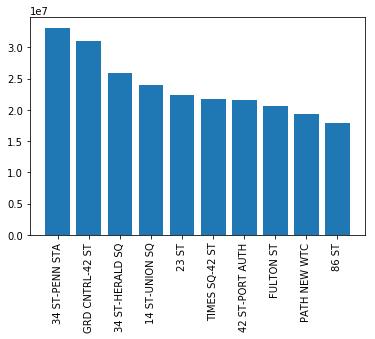

In [103]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['Total_Ridership_Per_day'][:10])
plt.xticks(rotation=90)

In [ ]:
#Top 10 Stations:
#1- 34 ST-PENN STA
#2-GRD CNTRL-42 ST
#3-34 ST-HERALD SQ
#4-14 ST-UNION SQ
#5-23 ST
#6-TIMES SQ-42 ST
#7-

In [ ]:
#I loaded the wifi locations table into my sqlite database and ran the following query to create binary values:


In [55]:
from sqlalchemy import create_engine

In [56]:
engine = create_engine("sqlite:///C:/Users/mai_a/Downloads/baby_names.db")

In [57]:
all_tables = engine.table_names()
all_tables

['all_data',
 'fulldata',
 'mta_data',
 'station_totals',
 'turnstile_data',
 'turnstile_data_withoutlines',
 'turnstiles_daily_entries',
 'turnstiles_daily_exits',
 'wifi_binary',
 'wifi_data',
 'wifi_data_withoutlines',
 'wifi_locations_updated']

In [58]:
wifi_data = pd.read_sql('SELECT * FROM wifi_binary;', engine)
wifi_data.head()

,StationName,StationComplex,Lines,Historical,Borough,County,Latitude,Longitude,WiFiAvailable,ATT,Sprint,TMobile,Verizon,Location,ATTbinary,Sprintbinary,TMobilebinary,Verizonbinary
0,1st Ave,1 AV L,L,No,Manhattan,New York County,40.730953,-73.981628,No,No,Yes,No,No,"(40.730953, -73.981628)",0,1,0,0
1,103rd St,103 ST 1,1,No,Manhattan,New York County,40.799446,-73.968379,No,Yes,Yes,Yes,Yes,"(40.799446, -73.968379)",1,1,1,1
2,103rd St,103 ST 6,6,No,Manhattan,New York County,40.790600,-73.947478,No,Yes,Yes,Yes,Yes,"(40.7906, -73.947478)",1,1,1,1
3,103rd St,103 ST BC,BC,No,Manhattan,New York County,40.796092,-73.961454,No,Yes,Yes,Yes,Yes,"(40.796092, -73.961454)",1,1,1,1
4,110th St,110 ST 6,6,No,Manhattan,New York County,40.795020,-73.944250,No,Yes,Yes,Yes,Yes,"(40.79502, -73.94425)",1,1,1,1


In [59]:
wifi_data.size

5094

In [60]:
wifi_data.dtypes

StationName        object
StationComplex     object
Lines              object
Historical         object
Borough            object
County             object
Latitude          float64
Longitude         float64
WiFiAvailable      object
ATT                object
Sprint             object
TMobile            object
Verizon            object
Location           object
ATTbinary           int64
Sprintbinary        int64
TMobilebinary       int64
Verizonbinary       int64
dtype: object

In [35]:
#now i will get for each provider the total yes and total no
#freq_table = pd.DataFrame(tor_2016_2017.loc[:, "W.L"].value_counts())
#freq_table.columns = ["Frequency"]
#freq_table

In [87]:
counts = pd.DataFrame(wifi_data.loc[:, "ATT"].value_counts())

In [88]:
counts

,ATT
Yes,151
No,132


In [89]:
counts['Sprint'] = wifi_data.loc[:, "Sprint"].value_counts()
counts.head()

,ATT,Sprint
Yes,151,186
No,132,97


In [90]:
counts['TMobile'] = wifi_data.loc[:, "TMobile"].value_counts()
counts.head()

,ATT,Sprint,TMobile
Yes,151,186,142
No,132,97,141


In [91]:
counts['Verizon'] = wifi_data.loc[:, "Verizon"].value_counts()
counts.head()

,ATT,Sprint,TMobile,Verizon
Yes,151,186,142,151
No,132,97,141,132


In [66]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
import seaborn as sns
import math 
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
#import sys
#!conda install --yes --prefix {sys.prefix} plotly

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\mai_a\Anaconda3

  added / updated specs: 
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    retrying-1.3.3             |     pyhd3eb1b0_2          15 KB
    conda-package-handling-1.3.11|           py37_0         280 KB
    conda-4.10.3               |   py37haa95532_0         3.1 MB
    plotly-4.14.3              |     pyhd3eb1b0_0         5.9 MB
    ------------------------------------------------------------
                                           Total:         9.3 MB

The following NEW packages will be INSTALLED:

    conda-package-handling: 1.3.11-py37_0      
    plotly:                 4.14.3-pyhd3eb1b0_0
    retrying:               1.3.3-pyhd3eb1b0_2 

The following packages will be UPDATED:

    conda:                  4.5.12-py37_0       --> 4.10.3-py37haa95532_0


Pr


retrying-1.3.3       | 15 KB     |            |   0% 
retrying-1.3.3       | 15 KB     | #######5   |  75% 
retrying-1.3.3       | 15 KB     | ########## | 100% 

conda-package-handli | 280 KB    |            |   0% 
conda-package-handli | 280 KB    | 4          |   4% 
conda-package-handli | 280 KB    | #######9   |  79% 
conda-package-handli | 280 KB    | ########## | 100% 

conda-4.10.3         | 3.1 MB    |            |   0% 
conda-4.10.3         | 3.1 MB    |            |   0% 
conda-4.10.3         | 3.1 MB    | 6          |   7% 
conda-4.10.3         | 3.1 MB    | #8         |  18% 
conda-4.10.3         | 3.1 MB    | ####2      |  43% 
conda-4.10.3         | 3.1 MB    | #####8     |  59% 
conda-4.10.3         | 3.1 MB    | #######6   |  77% 
conda-4.10.3         | 3.1 MB    | ########3  |  83% 
conda-4.10.3         | 3.1 MB    | ########7  |  88% 
conda-4.10.3         | 3.1 MB    | #########1 |  91% 
conda-4.10.3         | 3.1 MB    | #########4 |  94% 
conda-4.10.3         | 3.

In [165]:
import plotly.express as px
df = counts
# Use directly Columns as argument. You can use tab completion for this!
fig = px.bar(df, x=counts.index, y=["ATT", "Sprint", "TMobile", "Verizon"], title="Coverage Counts")
fig.show()

In [105]:
fig = px.bar(counts, x=counts.index, y=["ATT", "Sprint", "TMobile", "Verizon"],title="Coverage Availability")
fig.show()

In [112]:
wifi_data.head()

,StationName,StationComplex,Lines,Historical,Borough,County,Latitude,Longitude,WiFiAvailable,ATT,Sprint,TMobile,Verizon,Location,ATTbinary,Sprintbinary,TMobilebinary,Verizonbinary
0,1st Ave,1 AV L,L,No,Manhattan,New York County,40.730953,-73.981628,No,No,Yes,No,No,"(40.730953, -73.981628)",0,1,0,0
1,103rd St,103 ST 1,1,No,Manhattan,New York County,40.799446,-73.968379,No,Yes,Yes,Yes,Yes,"(40.799446, -73.968379)",1,1,1,1
2,103rd St,103 ST 6,6,No,Manhattan,New York County,40.790600,-73.947478,No,Yes,Yes,Yes,Yes,"(40.7906, -73.947478)",1,1,1,1
3,103rd St,103 ST BC,BC,No,Manhattan,New York County,40.796092,-73.961454,No,Yes,Yes,Yes,Yes,"(40.796092, -73.961454)",1,1,1,1
4,110th St,110 ST 6,6,No,Manhattan,New York County,40.795020,-73.944250,No,Yes,Yes,Yes,Yes,"(40.79502, -73.94425)",1,1,1,1


In [126]:
pd.DataFrame(wifi_data['StationName'].sort_values().unique())

,0
0,103rd St
1,110th St
2,110th St/Central Park N
3,110thSt
4,116th St
5,125th St
6,135th St
7,137th St
8,138th St
9,138th St-3rd Ave


In [127]:
pd.DataFrame(station_totals['STATION'].sort_values().unique())

,0
0,1 AV
1,103 ST
2,103 ST-CORONA
3,104 ST
4,110 ST
5,111 ST
6,116 ST
7,116 ST-COLUMBIA
8,121 ST
9,125 ST


In [141]:
no_tmob_cov = wifi_data.loc[(wifi_data['TMobilebinary'] == 0) & (wifi_data['ATTbinary'] == 1) & (wifi_data['Sprintbinary'] == 1) & (wifi_data['Verizonbinary'] == 1) ]

In [142]:
no_tmob_cov.head()

,StationName,StationComplex,Lines,Historical,Borough,County,Latitude,Longitude,WiFiAvailable,ATT,Sprint,TMobile,Verizon,Location,ATTbinary,Sprintbinary,TMobilebinary,Verizonbinary
22,149th S. Grand Concourse (LL),149/GRAND CONC 245,25,Yes,Bronx,Bronx County,40.818410,-73.926718,No,Yes,Yes,No,Yes,"(40.81841, -73.926718)",1,1,0,1
58,149th St-3rd Ave,3 AV-149 ST 25,25,No,Bronx,Bronx County,40.816109,-73.917757,No,Yes,Yes,No,Yes,"(40.816109, -73.917757)",1,1,0,1
194,Graham Ave,GRAHAM AV L,L,No,Brooklyn,Kings County,40.714565,-73.944053,No,Yes,Yes,No,Yes,"(40.714565, -73.944053)",1,1,0,1
203,Greenpoint Ave,GREENPOINT AV G,G,No,Brooklyn,Kings County,40.731352,-73.954449,No,Yes,Yes,No,Yes,"(40.731352, -73.954449)",1,1,0,1
224,59th St,"Lexington Av (N,R,W)/59 St (4,5,6)",456,No,Manhattan,New York County,40.762526,-73.967967,No,Yes,Yes,No,Yes,"(40.762526, -73.967967)",1,1,0,1


In [149]:
a = no_tmob_cov.groupby('StationName').sum().sort_values("TMobilebinary",ascending=False)
a.head()

,Latitude,Longitude,ATTbinary,Sprintbinary,TMobilebinary,Verizonbinary
StationName,,,,,,
149th S. Grand Concourse (LL),40.818410,-73.926718,1,1,0,1
149th St-3rd Ave,40.816109,-73.917757,1,1,0,1
51st St,40.757107,-73.971920,1,1,0,1
59th St,40.762526,-73.967967,1,1,0,1
Graham Ave,40.714565,-73.944053,1,1,0,1


In [152]:
df1 = a
# Use directly Columns as argument. You can use tab completion for this!
fig = px.bar(a, x=a.index, y=["ATTbinary", "Sprintbinary", "TMobilebinary", "Verizonbinary"], title="Stations Not Covered by T-Mobile")
fig.show()

In [128]:
wifi_data.head()

,StationName,StationComplex,Lines,Historical,Borough,County,Latitude,Longitude,WiFiAvailable,ATT,Sprint,TMobile,Verizon,Location,ATTbinary,Sprintbinary,TMobilebinary,Verizonbinary
0,1st Ave,1 AV L,L,No,Manhattan,New York County,40.730953,-73.981628,No,No,Yes,No,No,"(40.730953, -73.981628)",0,1,0,0
1,103rd St,103 ST 1,1,No,Manhattan,New York County,40.799446,-73.968379,No,Yes,Yes,Yes,Yes,"(40.799446, -73.968379)",1,1,1,1
2,103rd St,103 ST 6,6,No,Manhattan,New York County,40.790600,-73.947478,No,Yes,Yes,Yes,Yes,"(40.7906, -73.947478)",1,1,1,1
3,103rd St,103 ST BC,BC,No,Manhattan,New York County,40.796092,-73.961454,No,Yes,Yes,Yes,Yes,"(40.796092, -73.961454)",1,1,1,1
4,110th St,110 ST 6,6,No,Manhattan,New York County,40.795020,-73.944250,No,Yes,Yes,Yes,Yes,"(40.79502, -73.94425)",1,1,1,1


In [131]:
final_df = pd.read_csv("C:/Users/mai_a/Desktop/My_project_data/final_table.csv")
final_df.head(20)

,STATION,Total_Ridership_Per_day,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
5,TIMES SQ-42 ST,21739274,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
6,42 ST-PORT AUTH,21524706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,FULTON ST,20629474,No,No,No,No,0.0,0.0,0.0,0.0
8,FULTON ST,20629474,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
9,PATH NEW WTC,19364864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
final_df.dropna(how='any', inplace=True)

In [138]:
#dfObj.drop(['a' , 'b'], inplace=True)
final_df.drop([8], inplace=True)

In [139]:
final_df.head()

,STATION,Total_Ridership_Per_day,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0


In [140]:
final_df.reset_index()

,index,STATION,Total_Ridership_Per_day,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
5,5,TIMES SQ-42 ST,21739274,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
6,7,FULTON ST,20629474,No,No,No,No,0.0,0.0,0.0,0.0
7,10,86 ST,17897748,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
8,11,59 ST COLUMBUS,16573947,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
9,12,125 ST,15932565,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0


In [142]:
#turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")
final_df = final_df.drop(["index"], axis=1, errors="ignore")

In [143]:
final_df.head()

,STATION,Total_Ridership_Per_day,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0


In [144]:
final_df.to_csv("final_data.csv")

In [147]:
final_df = pd.read_csv("C:/Users/mai_a/Desktop/My_project_data/final_data.csv")

In [166]:
final_df.shape

(199, 11)

In [167]:
counts = pd.DataFrame(final_df.loc[:, "ATT"].value_counts())
counts

,ATT
Yes,100
No,99


In [168]:
counts['Sprint'] = final_df.loc[:, "Sprint"].value_counts()
counts['TMobile'] = final_df.loc[:, "TMobile"].value_counts()
counts['Verizon'] = final_df.loc[:, "Verizon"].value_counts()
counts

,ATT,Sprint,TMobile,Verizon
Yes,100,120,93,100
No,99,79,106,99


In [169]:
counts = counts.reset_index()

In [200]:
counts

,index,ATT,Sprint,TMobile,Verizon
0,Yes,100,120,93,100
1,No,99,79,106,99


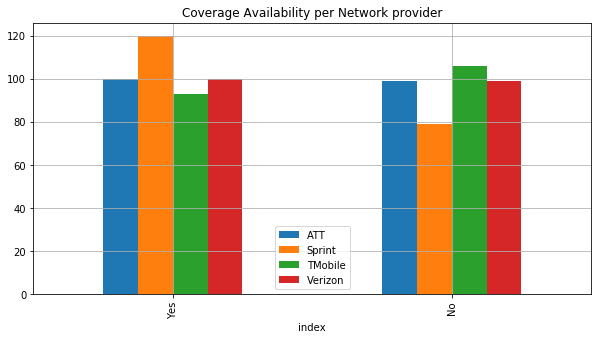

In [170]:
counts[["index", "ATT", "Sprint", "TMobile", "Verizon"]].plot(x="index", kind="bar", title="Coverage Availability per Network provider",figsize=(10,5),grid=True)

In [202]:
fig = px.bar(counts, x=counts["index"], y=["ATT", "Sprint", "TMobile", "Verizon"],title="Coverage Availability")
fig.show()

In [175]:
#chart the stations where tmobile is not providing coverage
#chart the stations where no providers are providing coverage
final_df.head()

,Unnamed: 0,STATION,Total_Ridership_Per_day,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0


In [177]:
final_df = final_df.rename(columns={'Total_Ridership_Per_day' : 'Total_Ridership'})
final_df.head()

,Unnamed: 0,STATION,Total_Ridership,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
1,1,GRD CNTRL-42 ST,30952006,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
2,2,34 ST-HERALD SQ,25913061,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0
3,3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
4,4,23 ST,22324682,Yes,Yes,Yes,Yes,1.0,1.0,1.0,1.0


In [178]:
#first we need to find the top stations with most trafic where tmobile isn't providing any coverage
no_cov_tmob = final_df[final_df['TMobilebirnary'] == 0]

In [179]:
no_cov_tmob.head()

,Unnamed: 0,STATION,Total_Ridership,ATT,Sprint,TMobile,Verizon,ATTbinary,Sprintbinary,TMobilebirnary,Verizonbinary
0,0,34 ST-PENN STA,33133152,No,No,No,No,0.0,0.0,0.0,0.0
3,3,14 ST-UNION SQ,23978084,No,No,No,No,0.0,0.0,0.0,0.0
6,7,FULTON ST,20629474,No,No,No,No,0.0,0.0,0.0,0.0
10,13,CANAL ST,15794586,No,Yes,No,No,0.0,1.0,0.0,0.0
11,14,59 ST,14271424,No,No,No,No,0.0,0.0,0.0,0.0


In [180]:
not_cov_by_any = final_df[(final_df['TMobilebirnary'] == 0) & (final_df['ATTbinary'] == 0) & (final_df['Sprintbinary'] == 0) & (final_df['Verizonbinary'] == 0)]

In [181]:
not_cov_by_any.dtypes

Unnamed: 0           int64
STATION             object
Total_Ridership      int64
ATT                 object
Sprint              object
TMobile             object
Verizon             object
ATTbinary          float64
Sprintbinary       float64
TMobilebirnary     float64
Verizonbinary      float64
dtype: object

In [195]:
import plotly.express as px
df = not_cov_by_any
fig = px.bar(df, x=df["STATION"][:20], y=df["Total_Ridership"][:20],title="Top 20 Stations Without Cellular Coverage",color_discrete_sequence=px.colors.qualitative.Set2)
fig.show()

In [198]:
df = no_cov_tmob
fig = px.bar(df, x=df["STATION"][:8], y=df["Total_Ridership"][:8], orientation='v', title="Top Stations Not Covered by T-Mobile", color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()